In [91]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import random
import warnings

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import timedcall
from sklearn.metrics import silhouette_score

#dimensions
from sklearn.decomposition import PCA

In [92]:
# load data
warnings.simplefilter("ignore")
df = pd.read_csv('Pokemon.csv')
df2 = df

In [93]:
# initial data exploration
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [95]:
df.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [96]:
df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [97]:
# fix missing values
df['Type 2_missing'] = df['Type 2'].isnull()
df['Type 2'].fillna('Missing', inplace=True)

In [98]:
# recheck missing values
df.isnull().sum()

#                 0
Name              0
Type 1            0
Type 2            0
Total             0
HP                0
Attack            0
Defense           0
Sp. Atk           0
Sp. Def           0
Speed             0
Generation        0
Legendary         0
Type 2_missing    0
dtype: int64

In [99]:
# unique values
unique_counts = df.nunique()
print(unique_counts)

#                 721
Name              800
Type 1             18
Type 2             19
Total             200
HP                 94
Attack            111
Defense           103
Sp. Atk           105
Sp. Def            92
Speed             108
Generation          6
Legendary           2
Type 2_missing      2
dtype: int64


In [100]:
# 1-hot encoding
original_df=df #creating a DF before feature engineering 
df = pd.get_dummies(df, columns=['Type 1', 'Type 2'])

In [101]:
# select numerical columns
numerical_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

In [102]:
# standardization
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [103]:
# outlier winsorizing
means = df[numerical_cols].mean()
stds = df[numerical_cols].std()


for col in numerical_cols:
    upper_limit = means[col] + 3 * stds[col]
    lower_limit = means[col] - 3 * stds[col]
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

In [104]:
df

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Missing,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,1,Bulbasaur,-0.976765,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,1,...,0,0,0,0,0,1,0,0,0,0
1,2,Ivysaur,-0.251088,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,1,...,0,0,0,0,0,1,0,0,0,0
2,3,Venusaur,0.749845,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,1,...,0,0,0,0,0,1,0,0,0,0
3,3,VenusaurMega Venusaur,1.583957,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,1,...,0,0,0,0,0,1,0,0,0,0
4,4,Charmander,-1.051836,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,1.375429,-0.754692,0.647369,2.443765,0.831146,2.808099,-0.629341,6,...,0,0,0,0,0,0,0,0,0,0
796,719,DiancieMega Diancie,2.209541,-0.754692,2.497104,1.160233,2.665905,1.369846,1.436611,6,...,0,0,0,0,0,0,0,0,0,0
797,720,HoopaHoopa Confined,1.375429,0.420917,0.955658,-0.444182,2.360112,2.088973,0.059310,6,...,0,0,0,0,0,0,0,0,0,0
798,720,HoopaHoopa Unbound,2.042718,0.420917,2.497104,-0.444182,2.971699,2.088973,0.403635,6,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# Clustering K-means
numerical_cluster = df[numerical_cols][['Attack','Sp. Atk']]
print(numerical_cluster)

       Attack   Sp. Atk
0   -0.924906 -0.239130
1   -0.524130  0.219560
2    0.092448  0.831146
3    0.647369  1.503891
4   -0.832419 -0.392027
..        ...       ...
795  0.647369  0.831146
796  2.497104  2.665905
797  0.955658  2.360112
798  2.497104  2.971699
799  0.955658  1.748526

[800 rows x 2 columns]


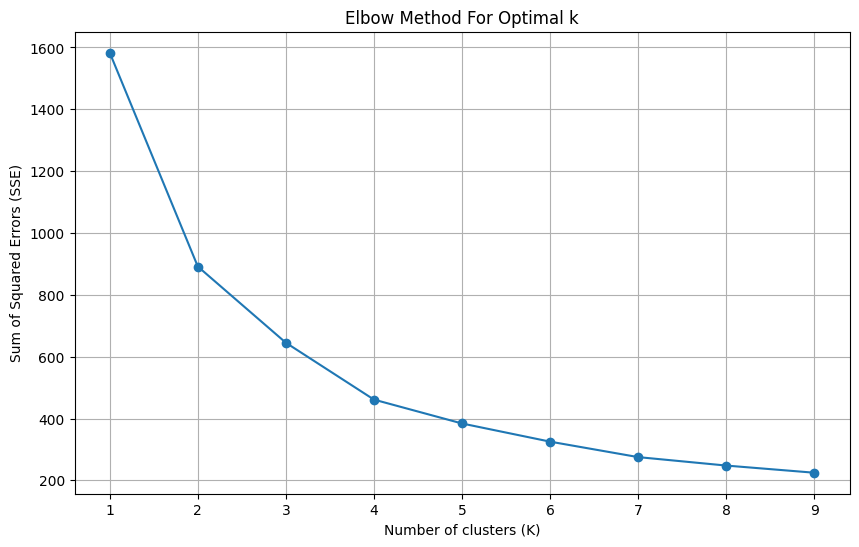

In [106]:
# Looking for optimal number of clusters-Elbow methond
sse = []
for K in range(1, 10):
    model = KMeans(n_clusters=K)
    model.fit(numerical_cluster)
    sse.append(model.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)


In [107]:
# The Elbow suggests 4 or 5  clusters to be optimal. We will choose 4.
model_cluster_Attack = KMeans(n_clusters=4,random_state=40)
model_cluster_Attack.fit(numerical_cluster)
center_Attack = model_cluster_Attack.cluster_centers_
labels_Attack = model_cluster_Attack.labels_
score_Attack = silhouette_score(numerical_cluster, labels_Attack)
print(center_Attack)
print(labels_Attack)
print(score_Attack)

[[ 0.81543918 -0.47891102]
 [-0.85954451 -0.7945286 ]
 [ 1.52173847  1.64024939]
 [-0.18373286  0.70958834]]
[1 3 3 2 1 3 3 2 2 1 1 3 2 1 1 3 1 1 0 0 1 1 3 3 1 0 1 0 1 0 1 3 1 0 1 1 0
 1 1 0 1 3 1 3 1 3 1 0 1 3 3 1 0 1 3 1 0 1 1 1 3 1 0 3 2 1 1 0 3 3 3 3 1 0
 0 3 3 3 1 3 1 0 0 0 0 1 3 3 3 3 1 0 0 1 3 1 0 1 3 3 3 3 3 1 1 3 0 0 1 3 1
 2 1 0 0 0 1 1 3 0 0 1 3 0 0 1 3 1 0 1 3 3 0 3 3 3 0 0 0 1 0 0 3 1 1 3 3 2
 3 3 3 0 0 0 0 0 3 3 2 1 0 2 2 2 2 3 1 1 3 1 3 3 1 0 0 1 1 1 1 1 1 1 0 0 1
 3 1 1 1 1 1 1 3 1 3 3 2 3 1 1 0 3 1 1 1 1 1 3 3 1 0 3 1 3 3 3 3 1 3 1 0 1
 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 3 1 0 1 1 2 1 1 1 3 3 2 3 1 0 3 3 1 1 0 1 1
 3 1 1 3 0 3 1 0 2 2 3 2 3 1 3 3 2 1 3 2 2 1 0 0 2 1 0 1 1 1 1 3 1 1 1 1 3
 1 1 3 1 0 1 3 1 1 3 2 1 3 1 0 1 0 2 1 0 0 1 3 3 1 0 1 1 1 1 1 3 0 0 1 0 0
 0 1 1 0 1 3 3 3 1 1 1 3 1 3 0 2 2 3 3 1 3 2 3 1 3 1 0 1 0 3 2 1 3 2 0 3 3
 0 1 3 0 0 1 3 1 3 0 0 1 3 3 0 1 0 2 1 1 3 3 0 2 1 1 3 2 1 3 3 3 3 3 0 1 1
 0 2 2 1 1 2 2 0 3 3 3 2 3 2 2 2 2 2 2 2 3 2 2 3 3 1 0 0 1 3 3 1 3

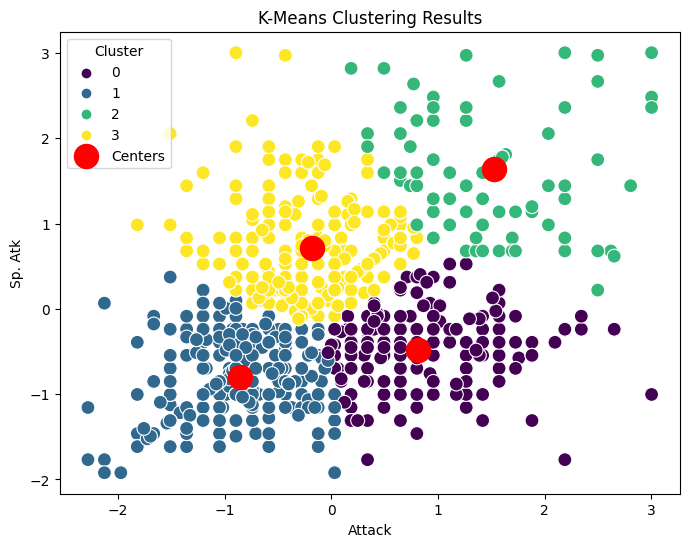

In [108]:
# Plotting the clusters
numerical_cluster['Cluster'] = labels_Attack
plt.figure(figsize=(8, 6))
sns.scatterplot(data= numerical_cluster , x='Attack', y='Sp. Atk', hue='Cluster', palette='viridis', s=100)
plt.scatter(center_Attack[:, 0], center_Attack[:, 1], s=300, c='red', label='Centers')  # Mark cluster centers
plt.title('K-Means Clustering Results')
plt.xlabel('Attack')
plt.ylabel('Sp. Atk')
plt.legend(title='Cluster')
plt.show()

[0 3 3 3 2 3 3 3 3 0 2 3 3 0 0 3 0 0 1 1 0 2 3 3 0 1 2 1 2 1 2 3 2 1 0 2 1
 2 2 1 0 3 0 3 0 3 0 1 2 3 3 2 1 0 3 0 1 0 2 2 3 2 1 3 3 0 2 1 3 3 3 3 2 1
 1 3 3 3 0 3 2 1 1 1 1 2 3 3 3 3 2 1 1 0 3 2 1 2 3 3 3 3 3 0 0 3 1 1 0 3 0
 3 0 1 1 1 2 2 3 1 1 0 3 1 1 0 3 2 1 0 3 3 1 3 3 3 1 1 1 0 1 1 3 0 0 3 3 3
 3 3 3 1 1 1 1 1 3 3 3 2 1 3 3 3 3 3 0 2 3 2 3 3 2 1 1 0 2 0 2 0 0 2 1 1 0
 3 0 0 0 0 0 2 3 0 3 3 3 3 0 0 1 3 0 0 2 2 0 3 3 0 1 3 2 3 3 3 3 0 3 2 1 2
 2 1 1 2 1 1 1 1 0 1 1 1 1 1 0 3 0 1 2 2 3 2 0 2 3 3 3 3 2 1 3 3 0 0 1 0 2
 3 2 0 3 1 3 2 1 3 3 3 3 3 0 3 3 3 2 3 3 3 2 1 1 3 0 1 0 2 0 0 3 0 0 0 0 3
 0 2 3 0 1 0 3 0 0 3 3 0 3 0 1 2 1 3 0 1 1 0 3 3 0 1 0 0 0 2 2 3 1 1 2 1 1
 1 0 2 1 0 3 3 3 0 2 0 3 0 3 1 3 3 3 3 2 3 3 3 0 3 2 1 2 1 3 3 0 3 3 1 3 3
 1 0 3 1 1 0 3 0 3 1 1 0 3 3 1 2 1 3 0 2 3 3 1 3 0 0 3 3 0 3 3 3 3 3 1 0 2
 1 3 3 0 2 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 1 2 3 3 2 3 3 0 2 1
 0 1 0 1 2 1 3 0 3 1 1 0 0 0 3 1 3 3 0 3 0 2 1 0 3 0 3 1 0 3 2 2 1 3 3 0 1
 0 2 1 0 3 2 0 0 3 3 2 1 

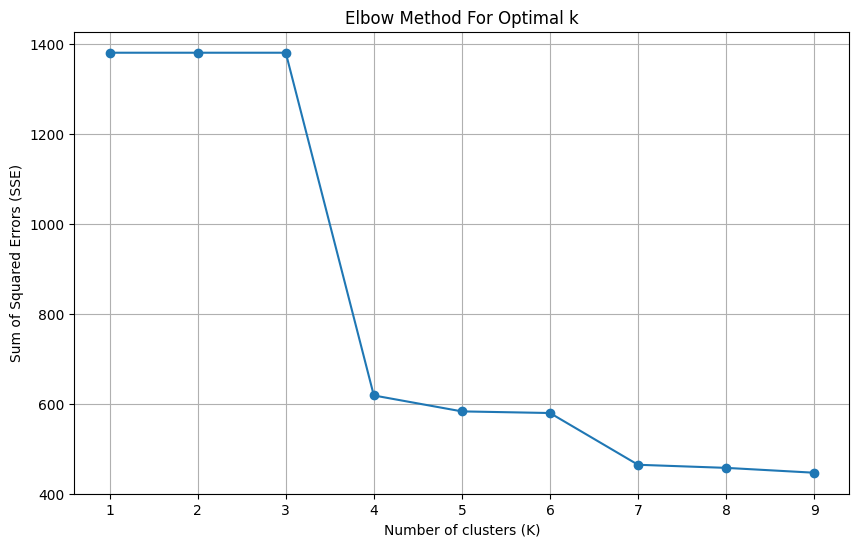

In [109]:
# Clustering PAM
pam_set = numerical_cluster
Pam_c = []
for K in range(1, 10):
    model = KMedoids(n_clusters=K)
    model.fit(pam_set)
    Pam_c.append(model.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), Pam_c, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)


model_PAM_Attack = KMedoids(n_clusters=4, random_state=40)
model_PAM_Attack.fit(pam_set)
center_Attack_pam =model_PAM_Attack.medoid_indices_
medoids = pam_set.iloc[center_Attack_pam,:]
labels_Attack_pam = model_PAM_Attack.labels_
pam_score = silhouette_score(numerical_cluster[['Attack','Sp. Atk']], labels_Attack_pam)
# print(center_Attack_pam)
print(labels_Attack_pam)
print(medoids)
print(pam_score)

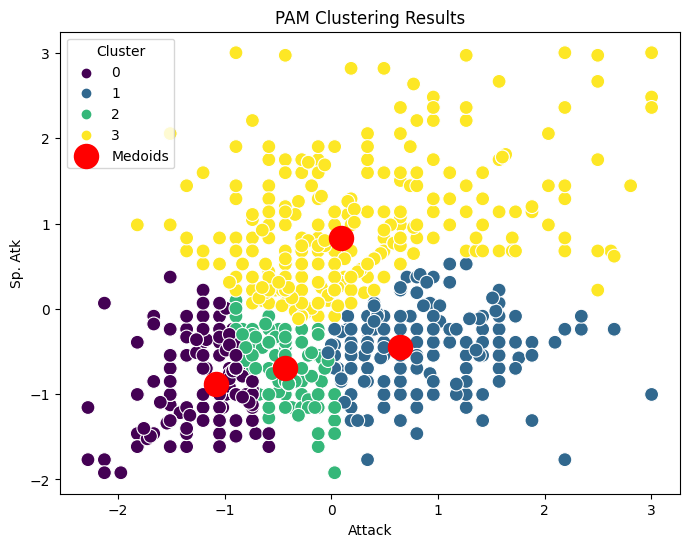

In [110]:
numerical_cluster['PAM_cluster'] =  labels_Attack_pam
plt.figure(figsize=(8, 6))
sns.scatterplot(data= numerical_cluster , x='Attack', y='Sp. Atk', hue='PAM_cluster', palette='viridis', s=100)
plt.scatter(medoids['Attack'], medoids['Sp. Atk'], s=300, c='red', label='Medoids')  # Mark cluster centers
plt.title('PAM Clustering Results')
plt.xlabel('Attack')
plt.ylabel('Sp. Atk')
plt.legend(title='Cluster')
plt.show()

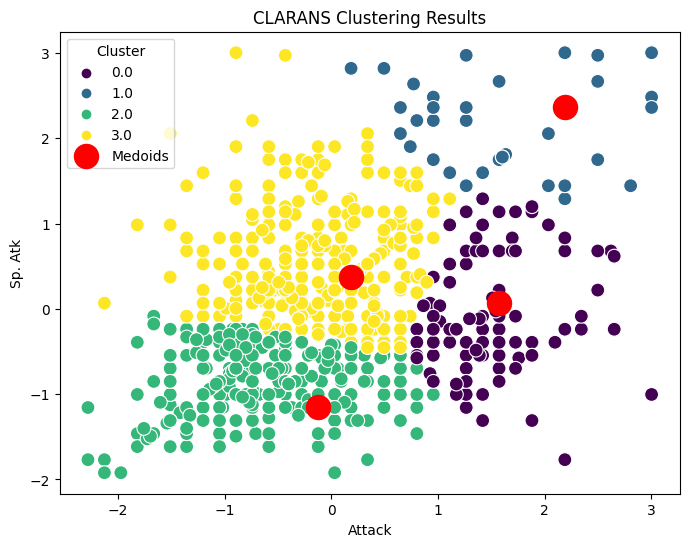

0.3527570095567674


In [111]:
# Clara clustering
random_state = 40  
random.seed(random_state)
np.random.seed(random_state)
clara_set = df[numerical_cols][['Attack','Sp. Atk']]
num_clusters = 4  
max_neighbors = 2  
num_local = 2  
clarans_array = clara_set.values
clarans_instance = clarans(clarans_array, num_clusters, max_neighbors, num_local)
clarans_instance.process()
clusters_cla = clarans_instance.get_clusters()
medoids_cla = clarans_instance.get_medoids()

df_clusters = pd.DataFrame(clarans_array,columns=['Attack', 'Sp. Atk'])

# Add a 'Cluster' column with the assigned cluster labels
for i, cluster in enumerate(clusters_cla):
    df_clusters.loc[cluster, 'Cluster'] = i  # Assign cluster index

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clusters, x='Attack', y='Sp. Atk', hue='Cluster', palette='viridis', s=100)

# Highlight medoids in red
medoids_cla_coords = df_clusters.loc[medoids_cla]  # Coordinates for medoids
plt.scatter(medoids_cla_coords['Attack'], medoids_cla_coords['Sp. Atk'], s=300, c='red', label='Medoids')

plt.title('CLARANS Clustering Results')
plt.xlabel('Attack')
plt.ylabel('Sp. Atk')
plt.legend(title='Cluster')
plt.show()
cla_score = silhouette_score(clara_set, df_clusters['Cluster'])
print(cla_score)

In [112]:
sil_score = [score_Attack, pam_score, cla_score]
algo = ['K-means','PAM','CLARANS']
sta = pd.DataFrame({'scores':algo,'value':sil_score})
print(sta)

    scores     value
0  K-means  0.392660
1      PAM  0.211713
2  CLARANS  0.352757


Type 1
Dragon      14
Fire        12
Psychic     10
Water        8
Dark         7
Electric     6
Grass        6
Steel        4
Rock         4
Ground       4
Normal       3
Fighting     3
Ghost        2
Ice          1
Flying       1
Fairy        1
Bug          1
dtype: int64


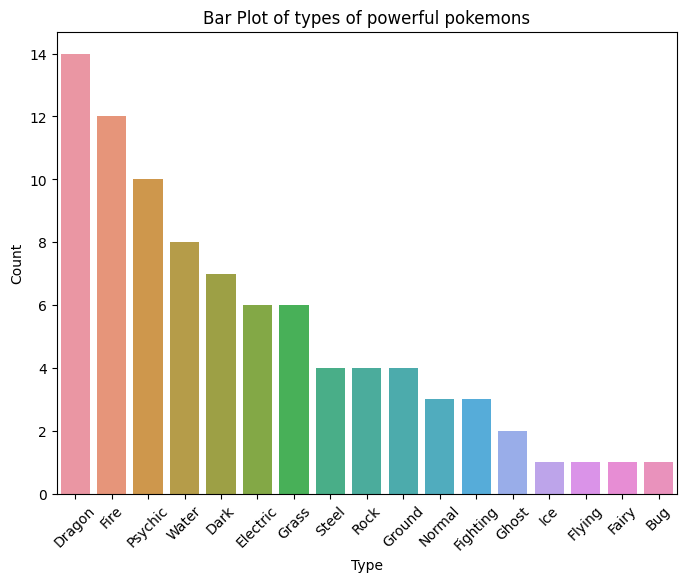

In [113]:
# Types based on K-means
# print(df.head())
clust_table = pd.concat([original_df['Type 1'], pd.DataFrame({'cluster':labels_Attack})], axis = 1)
powerful_table = clust_table[clust_table['cluster'] == 2]

# Group by 'Type 1' and count the number of occurrences
type_counts = powerful_table.groupby('Type 1').size().sort_values(ascending=False)
# powerful_table = clust_table.loc[ clust_table.cluster == 2, 'Type 1'].groupby('Type 1').count()
print(type_counts)
plt.figure(figsize=(8, 6))
sns.barplot(x=type_counts.index, y=type_counts.values)

# Set plot titles and labels
plt.title("Bar Plot of types of powerful pokemons")
plt.xlabel("Type")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Top 3 most powerful types :Dragon, Fire, Psychic

## <em>DIMENSION REDUCTION</em>

In [118]:
df

,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,...,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Missing,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
0,Bulbasaur,-0.976765,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,1,False,...,0,0,0,0,0,1,0,0,0,0
1,Ivysaur,-0.251088,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,1,False,...,0,0,0,0,0,1,0,0,0,0
2,Venusaur,0.749845,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,1,False,...,0,0,0,0,0,1,0,0,0,0
3,VenusaurMega Venusaur,1.583957,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,1,False,...,0,0,0,0,0,1,0,0,0,0
4,Charmander,-1.051836,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,1,False,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,1.375429,-0.754692,0.647369,2.443765,0.831146,2.808099,-0.629341,6,True,...,0,0,0,0,0,0,0,0,0,0
796,DiancieMega Diancie,2.209541,-0.754692,2.497104,1.160233,2.665905,1.369846,1.436611,6,True,...,0,0,0,0,0,0,0,0,0,0
797,HoopaHoopa Confined,1.375429,0.420917,0.955658,-0.444182,2.360112,2.088973,0.059310,6,True,...,0,0,0,0,0,0,0,0,0,0
798,HoopaHoopa Unbound,2.042718,0.420917,2.497104,-0.444182,2.971699,2.088973,0.403635,6,True,...,0,0,0,0,0,0,0,0,0,0


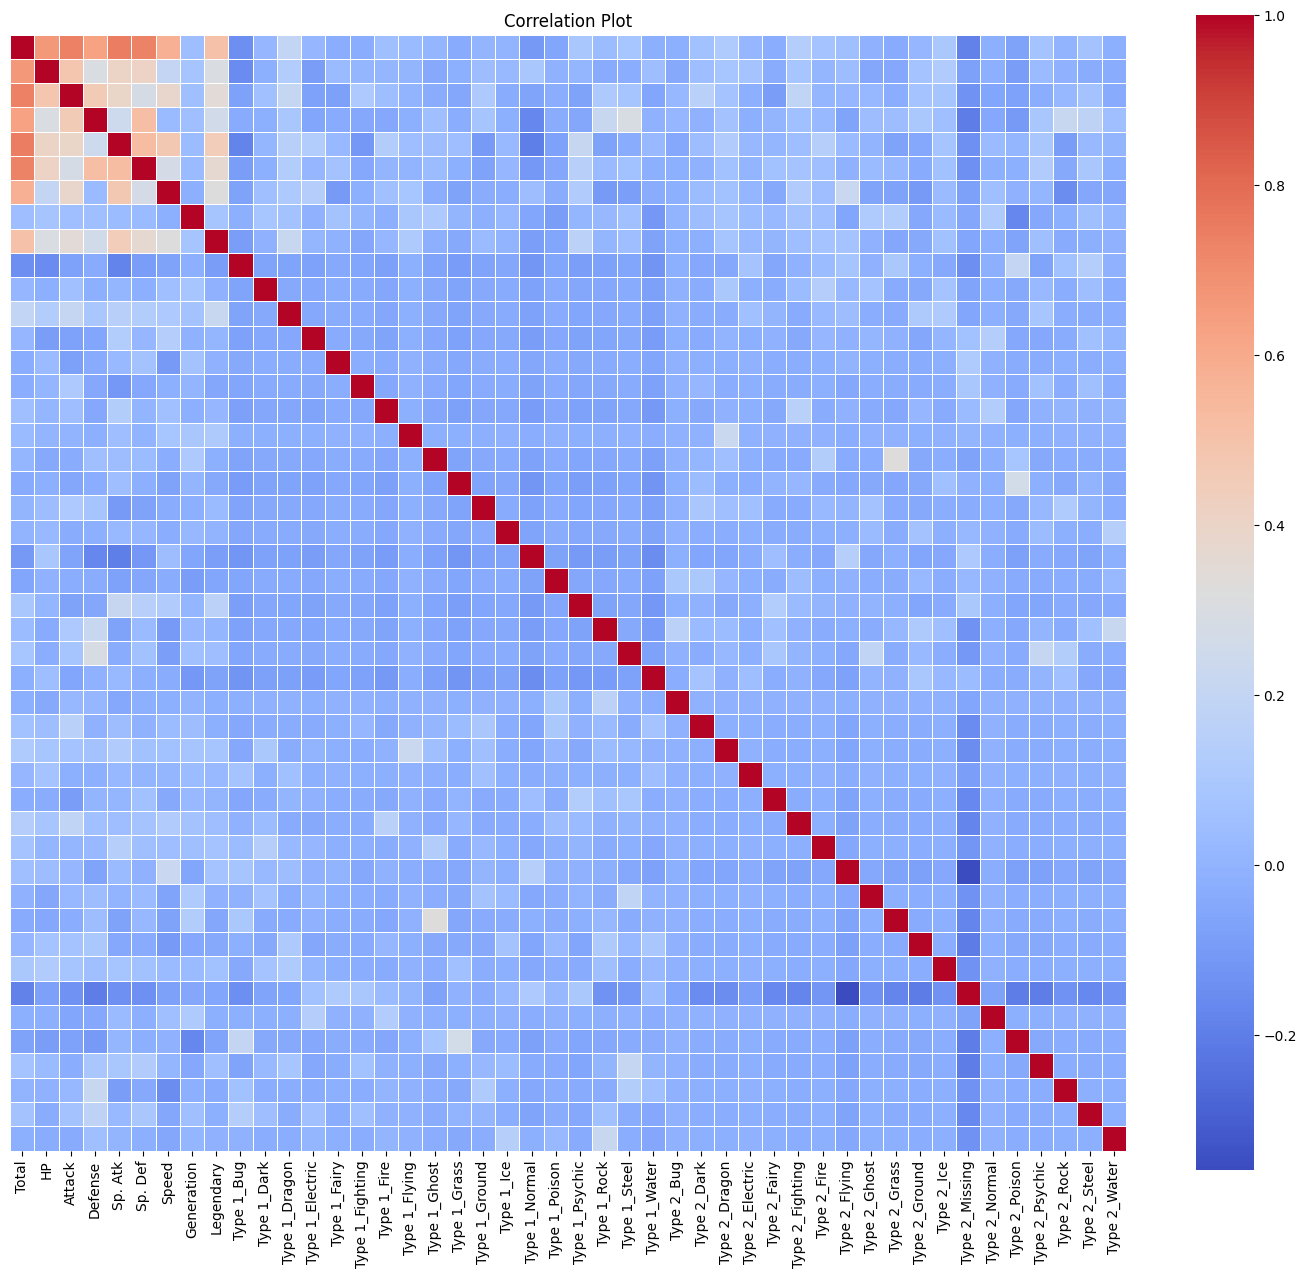

In [115]:
#deleting # column
df = df.iloc[:, 1:]
df = df.drop(columns=['Type 2_missing'])

#visualization of correlations
plt.figure(figsize=(18, 15))
df_corr = df.corr(method='pearson')

sns.heatmap(df_corr, cmap='coolwarm', cbar=True, square=True, linewidths=0.5, yticklabels=False)
plt.title('Correlation Plot')
plt.show()

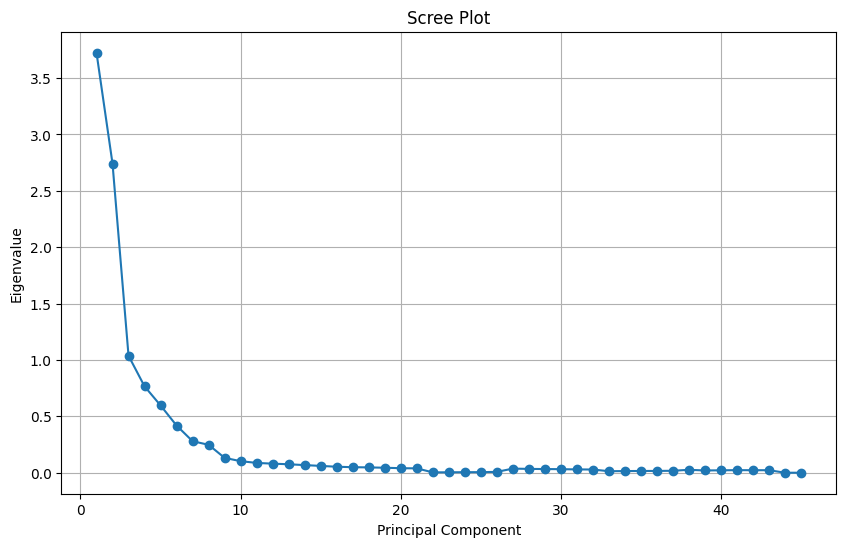

In [120]:
#taking out non numeriv
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

# Compute the covariance matrix
cov_matrix = np.cov(df_numeric.T)

# Compute the eigenvalues
eigenvalues, _ = np.linalg.eig(cov_matrix)

# Plot the eigenvalues (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

### based on the Scree plot and Kaiser Rule we choose that many dimensions as there are values above 1 
### so 3 dimensions in that case